In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pre_processing import *

import os

from sklearn.model_selection import train_test_split, GridSearchCV

from scipy.signal import spectrogram

import torch
import torch.nn.init as init
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax, Flatten, Dropout, Sigmoid, BCELoss
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
torch.manual_seed(42)
from dataclasses import dataclass

import skorch

from PIL import Image
from skimage.io import imread

from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class make_data(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.dataset = datasets.ImageFolder(self.data_dir, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((240, 320))])
dataset = make_data('pic_data/spectro/full_prsb/', transform=transform)

In [4]:
train_data, test_data = random_split(dataset, lengths=[0.8, 0.2])

In [5]:
train_loader = DataLoader(train_data, batch_size=10)
test_loader = DataLoader(test_data, batch_size=10)

In [20]:
iterator = iter(train_loader)
imgs, labels = next(iterator)

print(f'Number of images: {len(imgs)}')
print(f'Number of labels: {len(labels)}')
print(f'Shape of images batch: {np.array(imgs).shape}')

Number of images: 10
Number of labels: 10
Shape of images batch: (10, 3, 240, 320)


In [21]:
# Checking Sizes of Layers
conv1 = Conv2d(3,64,3)
pool = MaxPool2d(2,2)
conv2 = Conv2d(64,64,5)
img_conv1 = conv1(dataset[0][0])
img_pool1 = pool(img_conv1)
img_conv2 = conv2(img_pool1)
img_pool2 = pool(img_conv2)
img_conv3 = conv2(img_pool2)
img_pool3 = pool(img_conv3)

print(f'{img_conv1.shape=}')
print(f'{img_pool1.shape=}')
print(f'{img_conv2.shape=}')
print(f'{img_pool2.shape=}')
print(f'{img_conv3.shape=}')
print(f'{img_pool3.shape=}')

img_conv1.shape=torch.Size([64, 238, 318])
img_pool1.shape=torch.Size([64, 119, 159])
img_conv2.shape=torch.Size([64, 115, 155])
img_pool2.shape=torch.Size([64, 57, 77])
img_conv3.shape=torch.Size([64, 53, 73])
img_pool3.shape=torch.Size([64, 26, 36])


In [6]:
class cnn_maker(Module):
    def __init__(self):
        super(cnn_maker, self).__init__()
        self.conv1 = Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.conv3 = Conv2d(in_channels=64, out_channels=64, kernel_size=5)
        self.fc1 = Linear(64 * 26 * 36, 128)
        self.fc2 = Linear(128, 64)
        self.fc3 = Linear(64, 32)
        self.drop = Dropout()
        self.fc_f = Linear(32, 1)
        self.prob = Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64* 26 * 36)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        
        x = self.prob(self.fc_f(x))
        return x

In [20]:
cnn = cnn_maker()
cnn.to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adagrad(cnn.parameters(), lr=1e-2)

In [13]:
device

'cuda'

In [7]:
def train(model, train_loader, criterion, device):
    train_loss = 0.0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)  
        labels = labels.to(device) 

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape(-1, 1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    return train_loss / len(train_loader), accuracy

In [8]:
def validate(model, test_loader, criterion, device):
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  
            labels = labels.to(device)  

            outputs = model(inputs)
            loss = criterion(outputs, labels.reshape(-1, 1).float())
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        return val_loss / len(test_loader), accuracy

In [29]:
best_val_loss = float('inf')
for epoch in range(100):
    train_loss, train_accuracy = train(cnn, train_loader, criterion, device)
    val_loss, val_accuracy = validate(cnn, test_loader, criterion, device)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(cnn.state_dict(), 'model.p')
    
    else: 
        patience += 1
    """
    if patience > 3:
        print('Early stopping reached')
        break
    """
    print(f"Epoch: {epoch:02} - Train loss: {train_loss:02.3f} - Validation loss: {val_loss:02.3f} \n Train Accuracy: {train_accuracy:02.3f} - Val Accuracy: {val_accuracy:02.3f}")

Epoch: 00 - Train loss: 0.433 - Validation loss: 0.567 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 01 - Train loss: 0.426 - Validation loss: 0.578 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 02 - Train loss: 0.416 - Validation loss: 0.574 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 03 - Train loss: 0.403 - Validation loss: 0.585 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 04 - Train loss: 0.392 - Validation loss: 0.613 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 05 - Train loss: 0.380 - Validation loss: 0.592 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 06 - Train loss: 0.365 - Validation loss: 0.639 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 07 - Train loss: 0.343 - Validation loss: 0.674 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 08 - Train loss: 0.328 - Validation loss: 0.741 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 09 - Train loss: 0.308 - Validation loss: 0.754 
 Train Accuracy: 

Epoch: 80 - Train loss: 0.015 - Validation loss: 5.185 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 81 - Train loss: 0.015 - Validation loss: 5.245 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 82 - Train loss: 0.015 - Validation loss: 5.113 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 83 - Train loss: 0.014 - Validation loss: 4.992 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 84 - Train loss: 0.014 - Validation loss: 5.766 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 85 - Train loss: 0.014 - Validation loss: 5.461 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 86 - Train loss: 0.014 - Validation loss: 5.329 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 87 - Train loss: 0.014 - Validation loss: 6.094 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 88 - Train loss: 0.014 - Validation loss: 5.972 
 Train Accuracy: 63.383 - Val Accuracy: 60.159
Epoch: 89 - Train loss: 0.014 - Validation loss: 6.500 
 Train Accuracy: 

# Try the other method

In [31]:
from skorch.callbacks import EpochScoring
model = skorch.NeuralNetBinaryClassifier(cnn_maker, criterion = torch.nn.BCELoss, 
                                         optimizer = optim.Adagrad, max_epochs = 12, 
                                         batch_size = 10, device='cuda', 
                                         callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True)] 
                                        )
model.initialize()

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=cnn_maker(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=59904, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (drop): Dropout(p=0.5, inplace=False)
    (fc_f): Linear(in_features=32, out_features=1, bias=True)
    (prob): Sigmoid()
  ),
)

In [32]:
x = [] 
y = []
for i in train_loader:
    try:
        x.append(np.array(i[0]))
        y.append(np.array(i[1]))
    except:
        continue

In [33]:
x_full = np.concatenate(x, axis = 0)
y_full = np.concatenate(y, axis = 0)

In [34]:
model.fit(x_full, y_full.astype(np.float32))

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.6405        0.8720       0.7289        0.5950  14.5250
      2       0.6984        0.5678       0.6965        0.5603  14.3768
      3       0.7214        0.5593       0.7264        0.5358  14.4792
      4       0.7419        0.5331       0.7065        0.5611  14.4429
      5       0.7407        0.5191       0.7587        0.5206  14.3113
      6       0.7544        0.5146       0.7537        0.5062  14.3329
      7       0.7544        0.5031       0.7562        0.5075  14.3589
      8       0.7531        0.4983       0.7537        0.5060  14.4704
      9       0.7649        0.4881       0.7612        0.5091  14.4206
     10       0.7612        0.4781       0.7562        0.4925  14.4080
     11       0.7624        0.4694       0.7562        0.4844  14.3874

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=cnn_maker(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=59904, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (drop): Dropout(p=0.5, inplace=False)
    (fc_f): Linear(in_features=32, out_features=1, bias=True)
    (prob): Sigmoid()
  ),
)

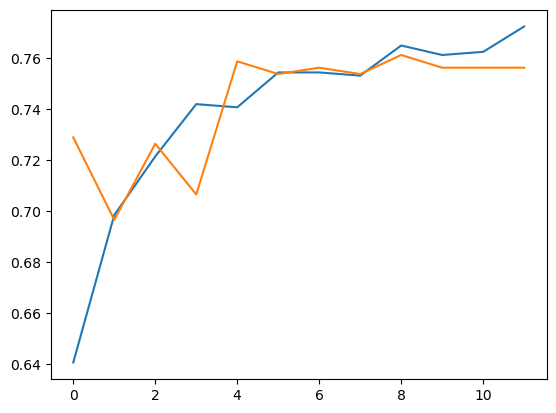

In [35]:
plt.plot(model.history[:, 'train_acc'])
plt.plot(model.history[:, 'valid_acc'])

In [36]:
import pickle as pkl
pkl.dump(model, open('cnn_model1.pkl', 'wb'))